In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import requests
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString
from itertools import combinations
from tqdm import tqdm
import math

In [2]:
root = '/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/'

## Step1: Load alternative attributes and model coefficients

In [3]:
choice_data_23 = pd.read_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/2.Joint mode and destination modeling/(1226) choice_dataset_v2.csv')
choice_data_23['(Intercept)'] = 1
choice_data_25 = pd.read_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/3.Model Calibration/(1226) choice_dataset_2025.csv')
choice_data_25['(Intercept)'] = 1
choice_data_25['Segment'] = choice_data_25['Pop_group'] + '_' + choice_data_25['Trip_purpose'] + '_' + choice_data_25['Time_period']
choice_data_23['Segment'] = choice_data_25['Segment']

choice_data_23['origin_county'] = choice_data_23['origin_county'].map(lambda x: '0'+str(x) if len(str(x))==4 else str(x))
choice_data_25['origin_county'] = choice_data_23['origin_county'].map(lambda x: '0'+str(x) if len(str(x))==4 else str(x))
choice_data_23['destination_county'] = choice_data_23['destination_county'].map(lambda x: '0'+str(x) if len(str(x))==4 else str(x))
choice_data_25['destination_county'] = choice_data_23['destination_county'].map(lambda x: '0'+str(x) if len(str(x))==4 else str(x))

choice_data = choice_data_25.copy(deep=True)

Segment_lst = ['NotLowIncome_Commute_Peak','NotLowIncome_Commute_Overnight','NotLowIncome_Other_Peak','NotLowIncome_Other_Overnight',
               'LowIncome_Commute_Peak','LowIncome_Commute_Overnight','LowIncome_Other_Peak','LowIncome_Other_Overnight',
               'Senior_Commute_Peak','Senior_Commute_Overnight','Senior_Other_Peak','Senior_Other_Overnight',
               'Student_Commute_Peak','Student_Commute_Overnight','Student_Other_Peak','Student_Other_Overnight']

info_name = ['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period','destination_county', 'origin_region', 
             'destination_region', 'mode']

segment_name = Segment_lst[10]
file_path = root + '2.Joint mode and destination modeling/Model Results 1226/IPDL_%s.xlsx'%segment_name
df = pd.read_excel(file_path, sheet_name="Coefficients")
attr_name = df["term"].tolist()
beta_name_R = [x for x in attr_name if x[:6]!='factor']
attr_name = [s.replace('log_s_s.county.','log_s_s(county)') for s in attr_name]
attr_name = [s.replace('log_s_s.mode.','log_s_s(mode)') for s in attr_name]
attr_name = [s.replace('County_36061.0','County_36061-0') for s in attr_name]
attr_name = [s.replace('County_36061.1','County_36061-1') for s in attr_name]
beta_name_Python = [x for x in attr_name if x[:6]!='factor']
del attr_name

In [4]:
def get_coeff(record):
    return coeff_dict[(record['Pop_group'],record['Trip_purpose'],record['Time_period'])]

coeff_dict = {}
for segment_name in Segment_lst:
    file_path = root + '2.Joint mode and destination modeling/Model Results 1226/IPDL_%s.xlsx'%segment_name
    df = pd.read_excel(file_path, sheet_name="Coefficients")    
    coeff = df[df['term'].isin(beta_name_R)]['estimate'].values
    population,purpose,period = segment_name.split('_')
    
    condition = choice_data['Segment']==segment_name
    coeff_dict[(population,purpose,period)] = coeff

coeff_23 = choice_data.apply(get_coeff,axis=1).values
coeff_23 = np.array([list(row) for row in coeff_23])

In [5]:
assert len(pd.DataFrame(coeff_23)[0].unique()) == 16
print(coeff_23.shape)
print('Number of attributes:',len(beta_name_Python))

(46378, 53)
Number of attributes: 53


In [6]:
def update_coeff(choice_data,beta_name_Python,coeff,adj):
    coeff_adj = coeff.copy()
    # Mode constant adjustment is only for trips from/to CRZ
    condition = (choice_data['destination_county']=='36061-1')|(choice_data['origin_county']=='36061-1')
    for attr in list(adj.keys())[:-1]:
        coeff_adj[condition,beta_name_Python.index(attr)] += adj[attr]
    # County constant adjustment is for all trips
    coeff_adj[:,beta_name_Python.index('County_36061-1')] += adj['County_36061-1']
    
    return coeff_adj

# adj={'constant_driving':0,'constant_transit':0,'constant_ondemand':0,'constant_biking':0,
#      'constant_walking':0,'County_36061-1-NYC':0,'County_36061-1-Other':0}
adj={'constant_driving':-0.280685,'constant_transit':0.326251,'constant_ondemand':0.170482,'constant_biking':-0.068060,
     'constant_walking':-0.068060,'County_36061-1':-0.289462}

coeff_25 = update_coeff(choice_data_25,beta_name_Python,coeff_23,adj)

In [7]:
print(coeff_23.shape)
print(coeff_25.shape)

(46378, 53)
(46378, 53)


## Step2: Calculate Systematic Utilities (V)

In [8]:
choice_data_23['beta_cost'] = coeff_23[:,beta_name_Python.index('cost_new')] + coeff_23[:,beta_name_Python.index('cost_new_NYC')]*choice_data_23['origin_region'].map(lambda x:1 if x in ['Manhattan','NYC'] else 0)
choice_data_25['beta_cost'] = coeff_25[:,beta_name_Python.index('cost_new')] + coeff_25[:,beta_name_Python.index('cost_new_NYC')]*choice_data_25['origin_region'].map(lambda x:1 if x in ['Manhattan','NYC'] else 0)
alpha_i = -choice_data_23.groupby('market_id')['beta_cost'].mean()

In [9]:
# X_before
X_before_ij = choice_data_23[beta_name_Python].copy()
X_before_ij['i_index'] = choice_data_23['market_id']
X_before_ij['j_index'] = choice_data_23['mode'] + '_' + choice_data_23['destination_county']
# beta_before
beta_before_ij = pd.DataFrame(coeff_23,columns=beta_name_Python)
beta_before_ij['i_index'] = choice_data_23['market_id']
beta_before_ij['j_index'] = choice_data_23['mode'] + '_' + choice_data_23['destination_county']
# X_after
X_after_ij = choice_data_25[beta_name_Python].copy()
X_after_ij['i_index'] = choice_data_25['market_id']
X_after_ij['j_index'] = choice_data_25['mode'] + '_' + choice_data_25['destination_county']

for col in beta_name_Python:
    # Find rows with inf or nan in X_after
    mask_inf = np.isinf(X_after_ij[col])
    mask_nan = pd.isna(X_after_ij[col])
    mask = mask_inf | mask_nan
    
    n_replaced = mask.sum()
    if n_replaced > 0:
        # Replace with values from X_before
        X_after_ij.loc[mask, col] = X_before_ij.loc[mask, col]
        print(f"  {col}: replaced {n_replaced} inf/nan values with X_before values")

# beta_after
beta_after_ij = pd.DataFrame(coeff_25,columns=beta_name_Python)
beta_after_ij['i_index'] = choice_data_25['market_id']
beta_after_ij['j_index'] = choice_data_25['mode'] + '_' + choice_data_25['destination_county']

  transit_nt: replaced 6 inf/nan values with X_before values


In [10]:
# delta_toll_X
delta_toll_X_ij = pd.DataFrame(np.zeros(X_before_ij.shape),columns=X_before_ij.columns)
delta_toll_X_ij['i_index'] = X_before_ij['i_index']
delta_toll_X_ij['j_index'] = X_before_ij['j_index']

def congestion_toll(record):
    region_condition = record['destination_county']=='36061-1' and record['origin_county']!='36061-1'
    if region_condition and record['Time_period']=='Overnight' and record['mode'] in ['driving','ondemand']:
        return 2.25
    elif region_condition and record['Time_period']=='Overnight' and record['mode'] in ['carpool']:
        return 2.25/2
    elif region_condition and record['Time_period']=='Peak' and record['mode'] in ['driving','ondemand']:
        return 9.00
    elif region_condition and record['Time_period']=='Peak' and record['mode'] in ['carpool']:
        return 9.00/2
    else:
        return 0

delta_toll_X_ij['cost_new'] = choice_data_23.apply(congestion_toll,axis=1)
delta_toll_X_ij['cost_new_NYC'] = delta_toll_X_ij['cost_new'] * choice_data_23['origin_region'].map(lambda x:1 if x in ['Manhattan','NYC'] else 0)
delta_toll_X_ij['auto_tt'] = X_after_ij['auto_tt'] - X_before_ij['auto_tt']
delta_toll_X_ij['auto_tt_NYC'] = X_after_ij['auto_tt_NYC'] - X_before_ij['auto_tt_NYC']

# delta_other_X
delta_other_X_ij = pd.DataFrame(np.zeros(X_before_ij.shape),columns=X_before_ij.columns)
delta_other_X_ij['i_index'] = X_before_ij['i_index']
delta_other_X_ij['j_index'] = X_before_ij['j_index']

delta_other_X_ij[beta_name_Python] = (X_after_ij[beta_name_Python] - X_before_ij[beta_name_Python]) - delta_toll_X_ij[beta_name_Python]

# delta_toll_beta
delta_toll_beta_ij = pd.DataFrame(coeff_25-coeff_23,columns=beta_name_Python)
delta_toll_beta_ij['i_index'] = beta_before_ij['i_index']
delta_toll_beta_ij['j_index'] = beta_before_ij['j_index']

In [42]:
prediction = pd.read_csv(root+'3.Model Calibration/(1226) trip_prediction.csv')
prediction['i_index'] = delta_toll_X_ij['i_index']
prediction['j_index'] = delta_toll_X_ij['j_index']

## Step 3: Shapley Value Decomposition for Consumer Surplus 

In [43]:
info_name = ['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period','Trip_num','origin_region']
info_data = choice_data.groupby('market_id').agg({'origin_county':'first','Pop_group':'first','Trip_purpose':'first',
                                                  'Time_period':'first', 'Trip_num':'sum','origin_region':'first'})

def get_region(record):
    if record['origin_county']=='36061-1':
        return 'CRZ'
    elif record['origin_region'] in ['PAS','CTS']:
        return 'CTS & PAS'
    else:
        return record['origin_region']
        
info_data['origin_region'] = info_data.apply(get_region,axis=1)

### Functions

In [1]:
def compute_logsum(V_ij, market_ids):
    """
    Compute logsum for each market (individual i).
    """
    df = pd.DataFrame({'V': V_ij, 'market_id': market_ids})
    df['exp_V'] = np.exp(df['V'])
    logsum = df.groupby('market_id')['exp_V'].sum().apply(np.log)
    return logsum

def compute_utility_with_factors(X_before, beta_before, factors, 
                                  delta_toll_X, delta_other_X, delta_toll_beta,
                                  beta_name):
    """
    Compute utility given a subset of factors turned "on".
    """
    V = np.sum(beta_before * X_before, axis=1)
    
    if 'A' in factors:
        V += np.sum(beta_before * delta_toll_X, axis=1)
    if 'B' in factors:
        V += np.sum(beta_before * delta_other_X, axis=1)
    if 'C' in factors:
        V += np.sum(delta_toll_beta * X_before, axis=1)
    if 'D' in factors:
        V += np.sum(delta_toll_beta * delta_toll_X, axis=1)
    if 'E' in factors:
        V += np.sum(delta_toll_beta * delta_other_X, axis=1)
    
    return V


def compute_characteristic_function(X_before, beta_before, 
                                     delta_toll_X, delta_other_X, delta_toll_beta,
                                     market_ids, alpha_i, beta_name):
    """
    Compute v(S) for all subsets S of factors.
    """
    all_factors = ['A', 'B', 'C', 'D', 'E']
    v = {}
    
    V_baseline = np.sum(beta_before * X_before, axis=1)
    LS_baseline = compute_logsum(V_baseline, market_ids)
    LS_baseline = check_results(LS_baseline, info_data)
    
    for r in range(6):
        for subset in combinations(all_factors, r):
            factors = set(subset)
            key = frozenset(factors)
            
            if len(factors) == 0:
                v[key] = pd.Series(0, index=LS_baseline.index)
            else:
                V_subset = compute_utility_with_factors(
                    X_before, beta_before, factors,
                    delta_toll_X, delta_other_X, delta_toll_beta,
                    beta_name
                )
                LS_subset = compute_logsum(V_subset, market_ids)
                LS_subset = check_results(LS_subset, info_data)
                v[key] = (LS_subset - LS_baseline) / alpha_i
    
    return v


def shapley_decomposition(v, all_factors=['A', 'B', 'C', 'D', 'E']):
    """
    Compute Shapley values for each factor.
    """
    n = len(all_factors)
    phi = {}
    
    for k in all_factors:
        phi_k = None
        other_factors = [f for f in all_factors if f != k]
        
        for r in range(n):
            for subset in combinations(other_factors, r):
                S = frozenset(subset)
                S_with_k = frozenset(subset) | {k}
                
                s = len(S)
                weight = math.factorial(s) * math.factorial(n - s - 1) / math.factorial(n)
                marginal = v[S_with_k] - v[S]
                
                if phi_k is None:
                    phi_k = weight * marginal
                else:
                    phi_k = phi_k + weight * marginal
        
        phi[k] = phi_k
    
    return phi


def run_shapley_decomposition(X_before_ij, beta_before_ij, X_after_ij, beta_after_ij,
                               delta_toll_X_ij, delta_other_X_ij, delta_toll_beta_ij,
                               alpha_i, beta_name_Python, prediction):
    """
    Main function to run the Shapley decomposition with trip weighting.
    
    Parameters:
    -----------
    X_before_ij, beta_before_ij, etc. : pd.DataFrame
        DataFrames with 'i_index', 'j_index' columns and attribute columns
    alpha_i : pd.Series
        Marginal utility of income for each market (indexed by market_id)
    beta_name_Python : list
        List of attribute names
    prediction : pd.DataFrame
        DataFrame with 'i_index', 'Trip_num_pred_23', 'Trip_num_pred_25' columns
    
    Returns:
    --------
    pd.DataFrame with columns including trip-weighted consumer surplus
    """
    # Extract numpy arrays for computation
    X_before = X_before_ij[beta_name_Python].values
    beta_before = beta_before_ij[beta_name_Python].values
    delta_toll_X = delta_toll_X_ij[beta_name_Python].values
    delta_other_X = delta_other_X_ij[beta_name_Python].values
    delta_toll_beta = delta_toll_beta_ij[beta_name_Python].values
    
    market_ids = X_before_ij['i_index']
    
    # =========================================================
    # Compute trip weights by market (sum over alternatives j)
    # =========================================================
    print("Computing trip weights by market...")
    trip_weights = prediction.groupby('i_index').agg({
        'Trip_num_pred_23': 'sum',
        'Trip_num_pred_25': 'sum'
    }).reset_index()
    trip_weights.columns = ['i_index', 'trips_23', 'trips_25']
    
    # Use average of 2023 and 2025 trips, or you can choose one
    # Option 1: Average
    trip_weights['trip_weight'] = (trip_weights['trips_23'] + trip_weights['trips_25']) / 2
    
    print(f"  Total trips (2023): {trip_weights['trips_23'].sum():,.0f}")
    print(f"  Total trips (2025): {trip_weights['trips_25'].sum():,.0f}")
    print(f"  Average trips used for weighting: {trip_weights['trip_weight'].sum():,.0f}")
    
    # =========================================================
    # Compute Shapley decomposition
    # =========================================================
    print("Computing characteristic function for all 32 subsets...")
    v = compute_characteristic_function(
        X_before, beta_before,
        delta_toll_X, delta_other_X, delta_toll_beta,
        market_ids, alpha_i, beta_name_Python
    )
    
    print("Computing Shapley values...")
    phi = shapley_decomposition(v)
    
    # =========================================================
    # Build result DataFrame
    # =========================================================
    result = pd.DataFrame({
        'i_index': alpha_i.index,
        'alpha_i': alpha_i.values,
        'phi_A': phi['A'].values,
        'phi_B': phi['B'].values,
        'phi_C': phi['C'].values,
        'phi_D': phi['D'].values,
        'phi_E': phi['E'].values
    })
    
    # Total CS change per trip = sum of all Shapley values
    result['total_CS_change_per_trip'] = (result['phi_A'] + result['phi_B'] + 
                                           result['phi_C'] + result['phi_D'] + result['phi_E'])
    
    # Attribution per trip
    result['CS_toll_per_trip'] = result['phi_A'] + result['phi_C'] + result['phi_D'] + result['phi_E']
    result['CS_other_per_trip'] = result['phi_B']
    
    # =========================================================
    # Merge trip weights and compute weighted CS
    # =========================================================
    result = result.merge(trip_weights, on='i_index', how='left')
    
    # Weighted consumer surplus (multiply by number of trips)
    result['phi_A_weighted'] = result['phi_A'] * result['trip_weight']
    result['phi_B_weighted'] = result['phi_B'] * result['trip_weight']
    result['phi_C_weighted'] = result['phi_C'] * result['trip_weight']
    result['phi_D_weighted'] = result['phi_D'] * result['trip_weight']
    result['phi_E_weighted'] = result['phi_E'] * result['trip_weight']
    
    result['total_CS_change'] = result['total_CS_change_per_trip'] * result['trip_weight']
    result['CS_toll'] = result['CS_toll_per_trip'] * result['trip_weight']
    result['CS_other'] = result['CS_other_per_trip'] * result['trip_weight']
    
    # =========================================================
    # Verify decomposition
    # =========================================================
    print("Verifying decomposition...")
    V_before = np.sum(beta_before * X_before, axis=1)
    X_after = X_after_ij[beta_name_Python].values
    beta_after = beta_after_ij[beta_name_Python].values
    V_after = np.sum(beta_after * X_after, axis=1)
    
    LS_before = compute_logsum(V_before, market_ids)
    LS_before = check_results(LS_before,info_data)
    LS_after = compute_logsum(V_after, market_ids)
    LS_after = check_results(LS_after,info_data)
    direct_CS_change_per_trip = (LS_after - LS_before) / alpha_i
    
    result['direct_CS_change_per_trip'] = direct_CS_change_per_trip.values
    result['direct_CS_change'] = result['direct_CS_change_per_trip'] * result['trip_weight']
    result['decomposition_error'] = result['total_CS_change'] - result['direct_CS_change']
    
    max_error = result['decomposition_error'].abs().max()
    print(f"Maximum decomposition error: {max_error:.2e}")
    
    return result

### Do it

In [45]:
# Run the decomposition
result_df = run_shapley_decomposition(
    X_before_ij, beta_before_ij, X_after_ij, beta_after_ij,
    delta_toll_X_ij, delta_other_X_ij, delta_toll_beta_ij,
    alpha_i, beta_name_Python, prediction
)

# ============================================================
# Display results
# ============================================================
print("\n" + "="*70)
print("SHAPLEY DECOMPOSITION RESULTS (TRIP-WEIGHTED)")
print("="*70)
print(f"\nTotal markets: {len(result_df)}")
print(f"Total trips (weighted): {result_df['trip_weight'].sum():,.0f}")

print(f"\n--- Aggregate Welfare Changes (Total $) ---")
print(f"  Total CS change:     ${result_df['total_CS_change'].sum():,.2f}")
print(f"  Toll-attributed:     ${result_df['CS_toll'].sum():,.2f}")
print(f"  Non-toll-attributed: ${result_df['CS_other'].sum():,.2f}")

print(f"\n--- Component Breakdown (Total $) ---")
print(f"  phi_A (toll attributes × original prefs):     ${result_df['phi_A_weighted'].sum():,.2f}")
print(f"  phi_B (other attributes × original prefs):    ${result_df['phi_B_weighted'].sum():,.2f}")
print(f"  phi_C (pref shift × baseline attributes):     ${result_df['phi_C_weighted'].sum():,.2f}")
print(f"  phi_D (pref shift × toll attributes):         ${result_df['phi_D_weighted'].sum():,.2f}")
print(f"  phi_E (pref shift × other attributes):        ${result_df['phi_E_weighted'].sum():,.2f}")

print(f"\n--- Per-Trip Averages ---")
total_trips = result_df['trip_weight'].sum()
print(f"  Avg CS change per trip:     ${result_df['total_CS_change'].sum()/total_trips:.4f}")
print(f"  Avg toll impact per trip:   ${result_df['CS_toll'].sum()/total_trips:.4f}")
print(f"  Avg other impact per trip:  ${result_df['CS_other'].sum()/total_trips:.4f}")

print(f"\n--- Verification ---")
print(f"  Sum of components:   ${result_df['total_CS_change'].sum():,.2f}")
print(f"  Direct calculation:  ${result_df['direct_CS_change'].sum():,.2f}")
print(f"  Max error:           ${result_df['decomposition_error'].abs().max():.2e}")

Computing trip weights by market...
  Total trips (2023): 70,910,622
  Total trips (2025): 70,969,495
  Average trips used for weighting: 70,940,059
Computing characteristic function for all 32 subsets...
Computing Shapley values...
Verifying decomposition...
Maximum decomposition error: 1.55e-08

SHAPLEY DECOMPOSITION RESULTS (TRIP-WEIGHTED)

Total markets: 496
Total trips (weighted): 70,940,059

--- Aggregate Welfare Changes (Total $) ---
  Total CS change:     $-789,469.49
  Toll-attributed:     $-1,088,309.50
  Non-toll-attributed: $298,840.01

--- Component Breakdown (Total $) ---
  phi_A (toll attributes × original prefs):     $-417,884.13
  phi_B (other attributes × original prefs):    $298,840.01
  phi_C (pref shift × baseline attributes):     $-670,425.37
  phi_D (pref shift × toll attributes):         $0.00
  phi_E (pref shift × other attributes):        $0.00

--- Per-Trip Averages ---
  Avg CS change per trip:     $-0.0111
  Avg toll impact per trip:   $-0.0153
  Avg other 

In [46]:
result_df_2 = result_df.merge(
    info_data,
    left_on='i_index',
    right_index=True,
    how='left'
)

# Save results
result_df_2.to_csv(root + '4.Distributional Impacts/(1226) shapley_decomposition_CS.csv', index=False)
print(f"\nResults saved.")


Results saved.


In [47]:
CRZ = gpd.read_file(root+'0.Geographic Boundary/NY_NJ_counties_crz_split.shp')
Counties = gpd.read_file(root+'0.Geographic Boundary/For New Study Area/MSA_counties.shp')
Counties = pd.concat([Counties[Counties['GEOID']!='36061'],CRZ[CRZ['GEOID'].isin(['36061-1','36061-0'])]],ignore_index=True)

Counties['lng'] = Counties.geometry.centroid.x
Counties['lat'] = Counties.geometry.centroid.y
aa = result_df_2.groupby('origin_county')['CS_toll'].sum().reset_index()
aa['origin_county'] = aa['origin_county'].map(lambda x:'0'+str(x) if len(str(x))==4 else str(x))
data = pd.merge(Counties[['GEOID','geometry','NAMELSAD']],aa,left_on='GEOID',right_on='origin_county')
data['NAMELSAD'] = data['NAMELSAD'].map(lambda x:x[:-7])
data['County_Name'] = data['origin_county']+': '+data['NAMELSAD']
data = data.sort_values(['origin_county'])

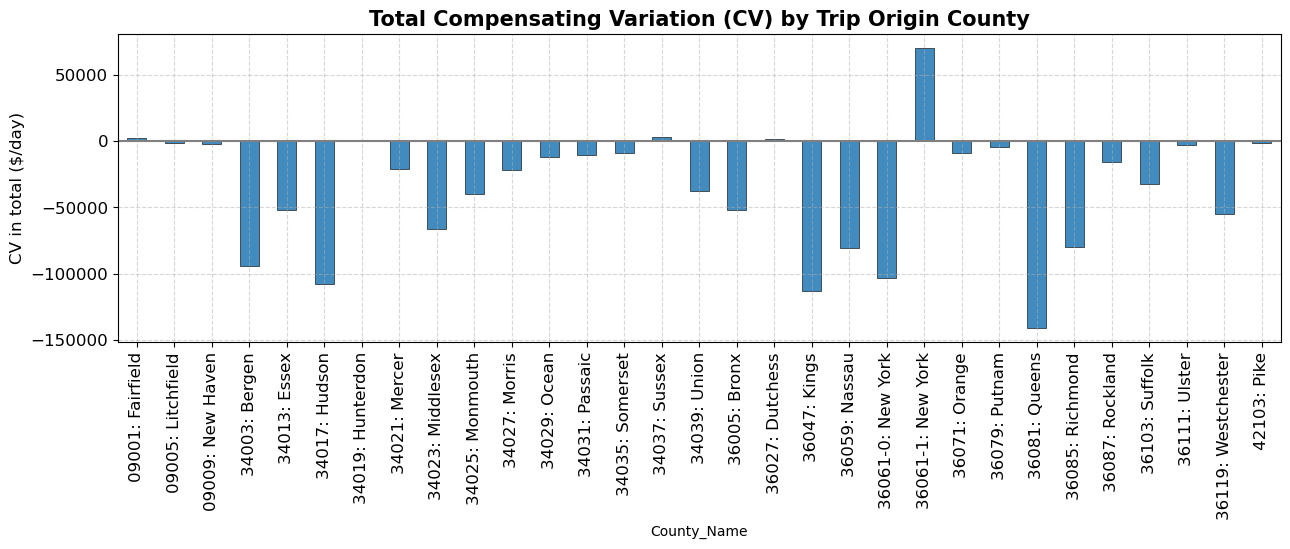

In [48]:
fig, ax = plt.subplots(figsize=(15,4))
data.set_index('County_Name')['CS_toll'].plot(kind='bar',figsize=(15,4),ax=ax,fontsize=12,edgecolor='black', linewidth=0.5,alpha=0.85)
plt.axhline(y=0,color='grey')
plt.ylabel('CV in total ($/day)',fontsize=12)
plt.title('Total Compensating Variation (CV) by Trip Origin County',fontsize=15, fontweight='bold')
plt.grid(linestyle='--',alpha=0.5)
plt.savefig('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/6.TR-A Revision/Figures/Figure 5.jpg', dpi=300, bbox_inches='tight')
plt.show()

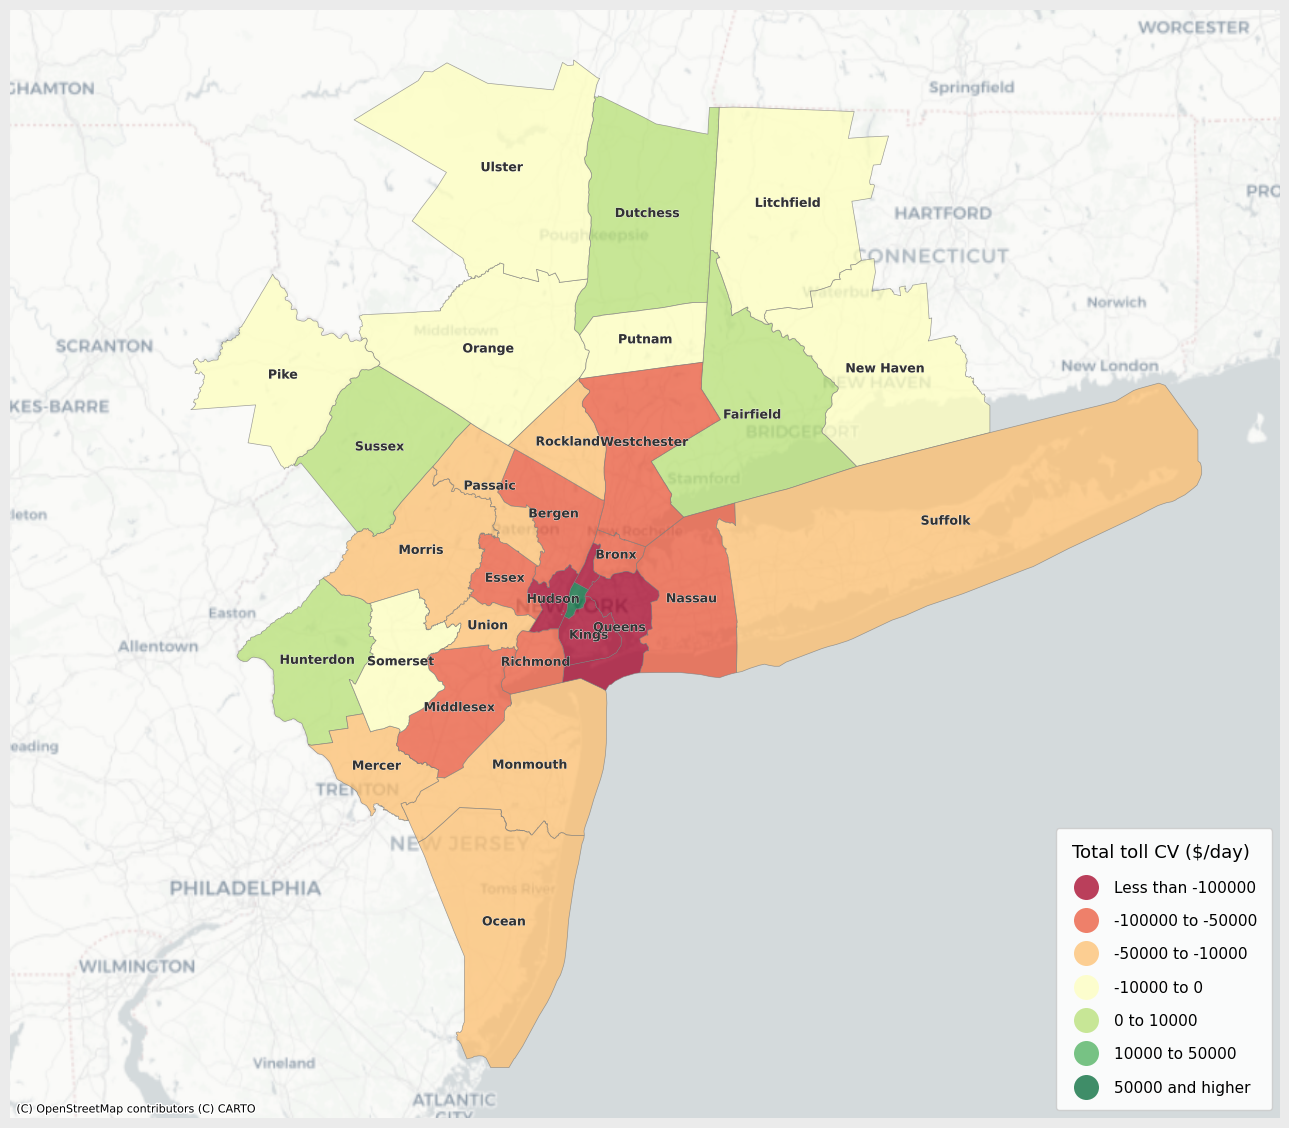

In [49]:
import contextily as cx
import mapclassify as mc
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(13,13), facecolor='#ebebeb')
my_bins = [-100000,-50000,-10000,0,10000,50000]
data['CS_toll'] = data['CS_toll'].astype(int)

# Create legend labels from the natural breaks bins
labels = [f"{my_bins[i]} to {my_bins[i+1]}" for i in range(len(my_bins)-1)]
labels = ['Less than '+str(my_bins[0])]+labels+[str(my_bins[-1]) + ' and higher']

data.plot(
    column='CS_toll',
    scheme='User_Defined',
    classification_kwds={'bins': my_bins},
    cmap='RdYlGn',
    edgecolor='grey',
    linewidth=0.5,
    legend=True,
    legend_kwds={
    "loc": "lower right",
    "labels": labels,
    "title": 'Total toll CV ($/day) ',
    "fontsize": 11,           # 图例文字大小
    "title_fontsize": 13,     # 标题文字大小
    "markerscale": 1.8,         # 图例标记放大倍数
    "framealpha": 0.9,        # 图例背景透明度
    "borderpad": 1,           # 图例边框内边距
    "labelspacing": 1.2       # 图例项之间的间距
    },
    ax=ax,
    alpha=0.75
)

ax.set_xlim(-76.0, -71.5)

# Use a more detailed basemap
cx.add_basemap(
    ax, 
    crs=data.crs.to_string(),
    source=cx.providers.CartoDB.Positron,  # More detailed than Positron
    zoom=8  # Higher zoom = more detail
)

ax.axis('off')

# Add county labels
for idx, row in data[~data['origin_county'].isin(['36061-0','36061-1'])].iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(
        x, y,
        row['NAMELSAD'],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=9,
        fontweight='bold',
        color='#333333',
        path_effects=[pe.withStroke(linewidth=0.5, foreground='white')]  # Add white outline for readability
    )

plt.tight_layout()
plt.savefig('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/6.TR-A Revision/Figures/Figure 6.jpg', dpi=300, bbox_inches='tight')
plt.show()

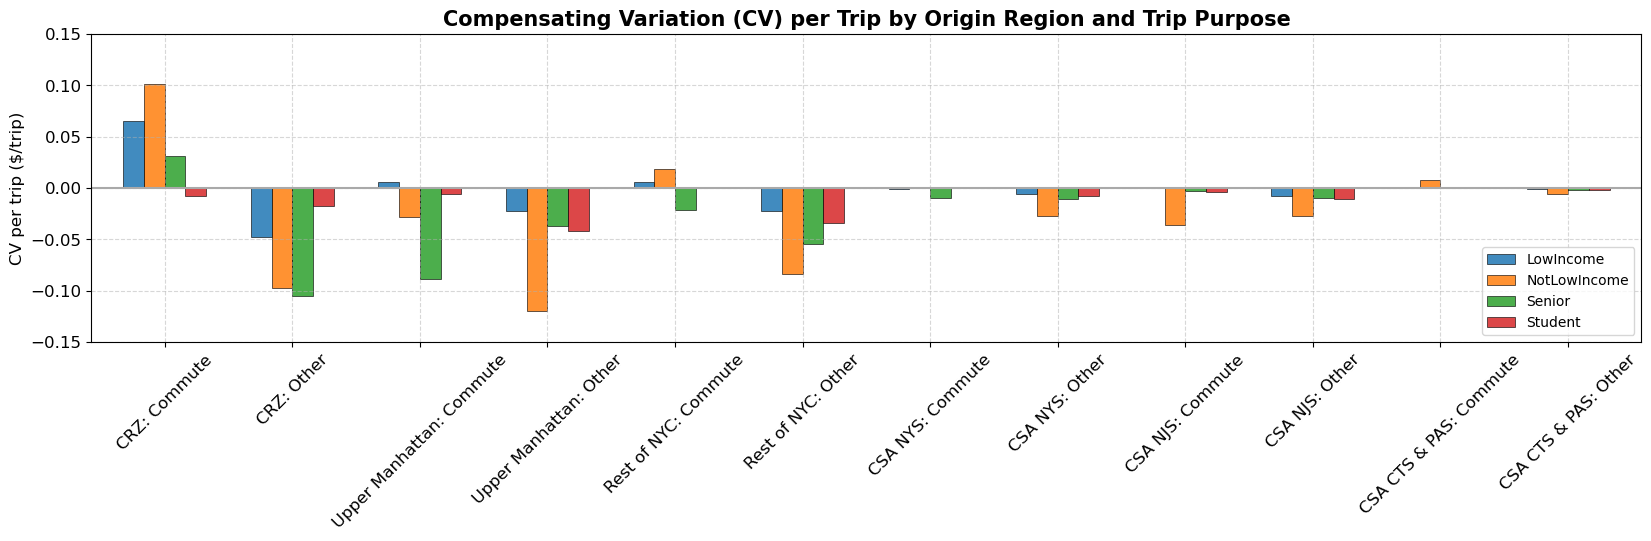

In [50]:
diff = result_df_2.copy()

diff = diff.groupby(['origin_region','Pop_group','Trip_purpose']).agg({'CS_toll':'sum','Trip_num':'sum'})
diff.reset_index(inplace=True)
diff['CS_toll_per_trip'] = diff['CS_toll']/diff['Trip_num']
pivot_df = diff.pivot_table(index=['origin_region', 'Trip_purpose'],columns='Pop_group',values='CS_toll_per_trip').fillna(0)

fig, ax = plt.subplots(figsize=(20,4))
#colors = ['#2853ad', '#fd6219', '#6dbf46', '#ec352f']
pivot_df = pivot_df.loc[[('CRZ','Commute'),('CRZ','Other'),('Manhattan','Commute'),('Manhattan','Other'),
                         ('NYC','Commute'),('NYC','Other'),('NYS', 'Commute'),('NYS','Other'),('NJS','Commute'),('NJS','Other'),
                         ('CTS & PAS', 'Commute'),('CTS & PAS','Other')]]
pivot_df.index = ['CRZ: Commute','CRZ: Other','Upper Manhattan: Commute','Upper Manhattan: Other',
                  'Rest of NYC: Commute','Rest of NYC: Other','CSA NYS: Commute','CSA NYS: Other','CSA NJS: Commute','CSA NJS: Other',
                  'CSA CTS & PAS: Commute','CSA CTS & PAS: Other']

pivot_df.plot(kind='bar',ax=ax, width=0.65,fontsize=12,edgecolor='black', linewidth=0.5,alpha=0.85) #color=colors
plt.axhline(y=0,color='darkgray')
plt.ylabel('CV per trip ($/trip)',fontsize=12)
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylim([-0.15,0.15])
plt.title('Compensating Variation (CV) per Trip by Origin Region and Trip Purpose',fontsize=15, fontweight='bold')
plt.grid(linestyle='--',alpha=0.5)
plt.legend(loc='lower right')
plt.savefig('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/6.TR-A Revision/Figures/Figure 7.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
aa = (467.8 + 56.9*2) * 0.9
print('Yealy Profit:', aa, 'million')

Yealy Profit: 523.44 million


In [52]:
bb = (45.9+50.1+49.4)*1000000/(30+31+30) * 0.9
print('Daily Profit in Q2:',round(bb), '$')

Daily Profit in Q2: 1438022 $


In [53]:
cc = result_df_2['CS_toll'].sum()
print('Daily CS Loss:', round(cc), '$')

Daily CS Loss: -1088310 $


In [54]:
-cc/bb

np.float64(0.7568100609367716)